# **Image Summarization with BLIP Model**

This Python script leverages the BLIP (Bootstrapped Language-Image Pretraining) model from Salesforce to generate summaries about images. By utilizing advanced deep learning techniques, this tool offers a simple way to convert visual data into meaningful text, enhancing accessibility and understanding of image content.

## **Overview of the Code**
The code is structured into several key components, each responsible for specific tasks, from loading and processing the image to generating and displaying the resulting description.











## **Required Libraries**
1. PyTorch: For running the deep learning models on either GPU or CPU.
2. Transformers: For loading and using the BLIP model.
3. Pillow (PIL): For image processing.
4. Matplotlib: For displaying the image and the caption.
5. python-multipart


In [ ]:
!pip install torch torchvision transformers pillow
!pip install python-multipart

## **Key Components**
1. Importing Libraries: The script begins by importing essential libraries:

  * **torch:** The core library for tensor computation and deep learning operations.
  * **PIL:** The Python Imaging Library, used for opening and manipulating image files.
  * **matplotlib.pyplot:** A plotting library to visualize images and their captions.
  * **transformers:** A library from Hugging Face that provides pre-trained models and processing utilities for natural language processing (NLP) and image captioning and summarization tasks.


In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration

2. Loading the BLIP Model: [link text](https://)The script initializes the BLIP model and its corresponding processor:

  * The BlipProcessor handles the image preprocessing and input formatting required by the model.
  * The BlipForConditionalGeneration is the actual model used for generating captions based on the processed images.
  * The model is moved to the GPU (if available) for faster computation.



In [7]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

3. Generating Image Descriptions: The function generate_image_description is responsible for loading an image, processing it, and generating a caption:

  * The image is loaded and converted to RGB format to ensure compatibility with the model.
  *The image is then processed into a format suitable for the BLIP model.
  *The model generates a caption with a maximum length of 150 tokens, utilizing beam search for improved quality and coherence of the generated text.
  *The generated output is decoded into a human-readable format.

In [8]:
def generate_image_description(image_path):
    """
    Generate a detailed description for the image using the BLIP model.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare the inputs for BLIP
    inputs = blip_processor(images=image, return_tensors="pt").to("cuda")

    # Generate the description
    output = blip_model.generate(**inputs, max_length=150, num_beams=5, early_stopping=True)
    description = blip_processor.decode(output[0], skip_special_tokens=True)

    return image, description


4. Displaying the Image and Description: The function display_image_and_description is used to visualize the image along with its generated caption

  * A Matplotlib figure is created, and the image is displayed without axes for a cleaner look.
  * The generated description is set as the title of the image, allowing users to quickly understand the content.


In [9]:
def display_image_and_description(image, description):
    """
    Display the image and its generated description.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title(description, fontsize=14)  # Show the description as the title
    plt.show()


5. Example Usage: The script concludes with an example of how to use the functions defined

  * The user is expected to replace the image_path variable with the path to their image file.
  * The image and its description are generated and displayed when the script is executed.


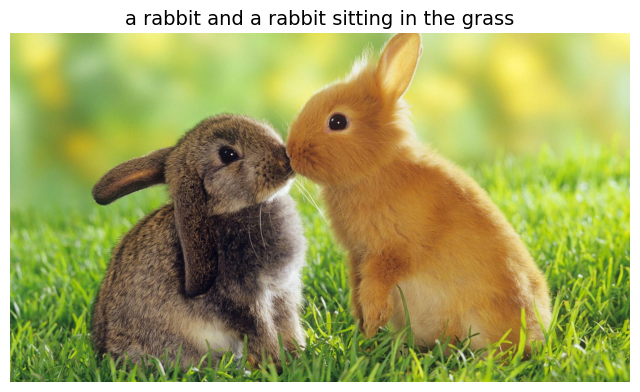

In [10]:
# Example usage
image_path = "your path"  # Replace with the path to your image
image, description = generate_image_description(image_path)
display_image_and_description(image, description)


## **Fine-Tunning the Model**

Further we can improve the model performance by adding a few more parameters in model processors.

1. First I have added autocast that will enable us to carry out mixed precision i.e in the context of deep learning, mixed precision refers to the practice of using both 16-bit and 32-bit floating-point numbers in model training and inference.

2. Then we are generating description with beam search combined with sampling. This will enhance the quality and uniqueness of descriptions generated.

There are various other ways to improve model performance; good image processing and finetuning with a relevant dataset.

<ipython-input-11-862a9a32cb8e>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


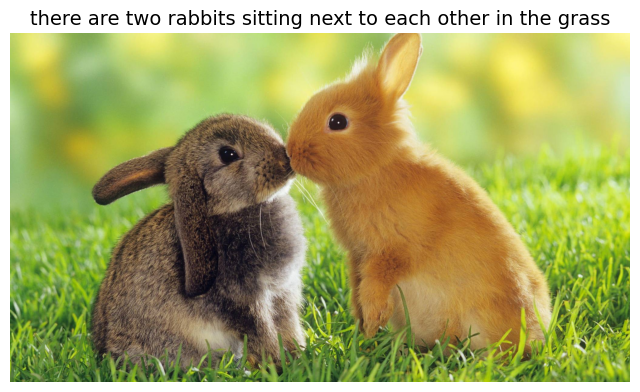

In [11]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.cuda.amp import autocast

# Load the larger BLIP model and processor for improved performance
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

def generate_image_description(image_path, max_length=200, num_beams=7, do_sample=False, top_k=50, top_p=0.95, temperature=0.7):
    """
    Generate a detailed description for the image using the BLIP model.
    Improvements include:
    - Larger model for better performance.
    - Adjustable beam search and sampling options for diversity and quality.
    - Mixed precision for faster inference.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare the inputs for BLIP
    inputs = blip_processor(images=image, return_tensors="pt")

    # Use autocast for mixed precision inference
    with autocast():
        # Generate the description with sampling or beam search
        output = blip_model.generate(
            **inputs,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
            do_sample=do_sample,  # Enable sampling if specified
            top_k=top_k if do_sample else None,  # Apply top-k sampling if do_sample is True
            top_p=top_p if do_sample else None,  # Apply top-p (nucleus) sampling if do_sample is True
            temperature=temperature if do_sample else None,  # Adjust temperature for randomness in sampling
        )

    # Decode the generated output
    description = blip_processor.decode(output[0], skip_special_tokens=True)

    return image, description

def display_image_and_description(image, description):
    """
    Display the image and its generated description.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title(description, fontsize=14)  # Show the description as the title
    plt.show()

# Example usage
image_path = "your path"  # Replace with the path to your image

# Adjust parameters for better performance
image, description = generate_image_description(
    image_path,
    max_length=200,  # Allow for longer descriptions
    num_beams=7,     # Increase beams for better quality
    do_sample=True,  # Enable sampling for more creative captions
    top_k=50,        # Top-k sampling
    top_p=0.95,      # Nucleus sampling
    temperature=0.7  # Control randomness
)

# Display the image and its description
display_image_and_description(image, description)


## **Conclusion**
This project demonstrates the application of advanced AI models for image captioning using the BLIP (Bootstrapped Language-Image Pretraining) model. By utilizing this model, we are able to generate meaningful, detailed descriptions of images, transforming visual data into human-readable text. This has various applications, listed below.

The project also incorporates Python libraries such as PyTorch for running deep learning models, Transformers for leveraging pre-trained models, and PIL and Matplotlib for image handling and visualization. The dynamic caption generation system is flexible and can be applied to a wide range of images, making it a robust tool for image understanding tasks.

With further improvements, such as integrating it into web applications or expanding the model's scope, this project can serve as a valuable foundation for AI-powered image processing and natural language generation applications.


Few example usage of this project can be:
1. Photo Archiving and Tagging Systems
2. Automatic Captioning for News and Media Outlets
3. Content Moderation with Descriptive Summaries of Uploaded Images
4. Interactive Storytelling Applications Using AI
5. AI-powered Presentation Tools for Auto-generating Slide Descriptions







